In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
#import pyDOE
from sepia.SepiaModel import SepiaModel
from sepia.SepiaData import SepiaData
import sepia.SepiaPlot as SepiaPlot
from sepia.SepiaOptim import SepiaOptim

In [3]:
import os
datadir = os.getcwd()+"/data/data_ball_drop_2/"
# experimental data
with open(datadir+'fieldDat15x6gparam.txt','r') as f:
    field_data = np.loadtxt(f)
with open(datadir+'desNative4x2Rrho.txt','r') as f:
    x = np.loadtxt(f) # x = {R, rho_ball}
x_obs = x

y_obs = [np.array(field_data[0:3,4]),np.array(field_data[3:6,4]),\
         np.array(field_data[6:12,4]),np.array(field_data[12:,4])]
h_obs = [np.array(field_data[0:3,3]),np.array(field_data[3:6,3]),\
         np.array(field_data[6:12,3]),np.array(field_data[12:,3])]# observed heights

# simulated data
with open(datadir+'desNative80x4Cg.txt','r') as f:
    sim_data = np.loadtxt(f)
x_sim = sim_data[:,0:2] # x = {R, rho_ball}
t_sim = sim_data[:,2:4] # t = {C, g}
with open(datadir+'simHeights101x1','r') as f:
    h_sim = np.loadtxt(f)
with open(datadir+'sims101x80Cg.txt','r') as f:
    y_sim = np.loadtxt(f).T

# create sepia data object
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_ind_sim = h_sim, y_sim = y_sim,\
                 x_obs = x, y_obs = y_obs, y_ind_obs = h_obs)

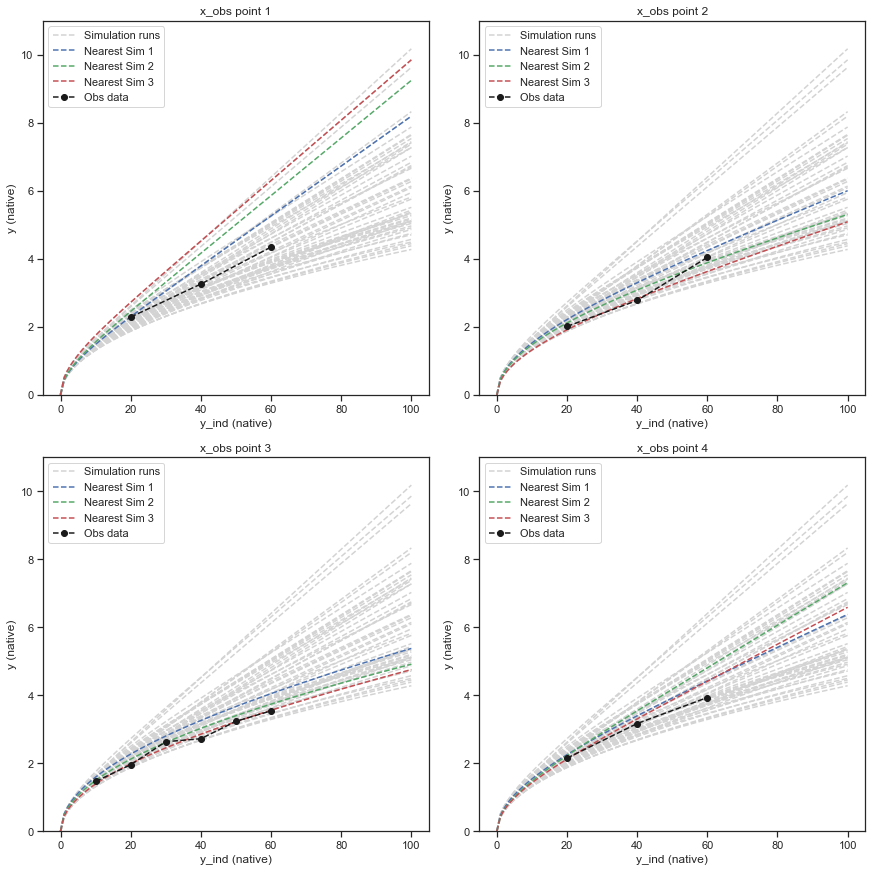

In [4]:
data_figure = data.plot_data(x_min = -5, x_max = 105, y_min = 0, y_max = 11)

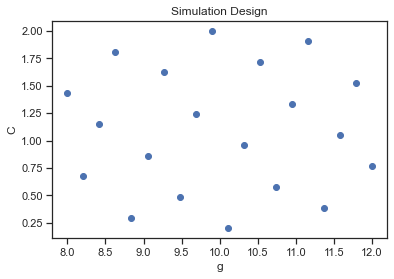

In [5]:
fig,ax = plt.subplots()
ax.scatter(t_sim[0:20,1],t_sim[0:20,0])
ax.set_xlabel("g");ax.set_ylabel("C"),ax.set_title("Simulation Design")
plt.show()

In [6]:
data.transform_xt()
data.standardize_y()

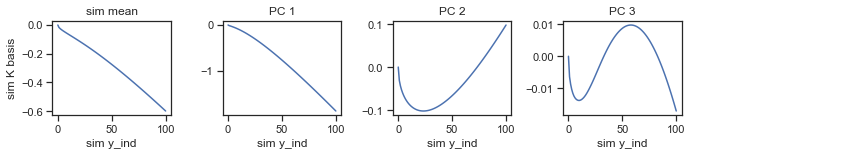

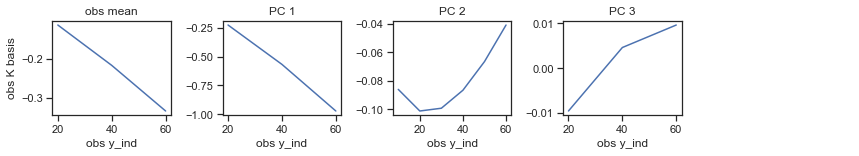

In [7]:
data.create_K_basis(3)
fig_sim, fig_obs = data.plot_K_basis()

In [8]:
data.create_D_basis('linear')
print(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 101, obs y dimension ragged
n  =     4 (number of observed data)
m  =    80 (number of simulated data)
p  =     2 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =     2 (transformed discrepancy dimension)



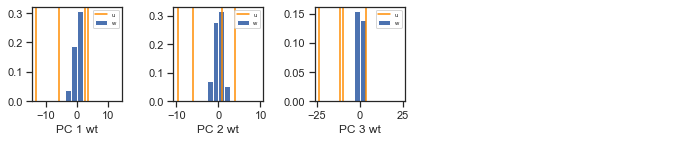

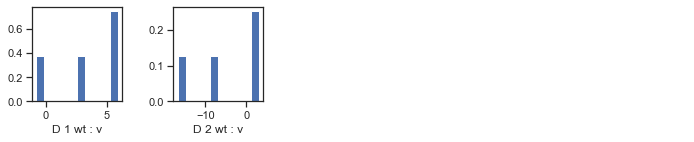

In [9]:
fig_uw, fig_v = data.plot_K_weights()

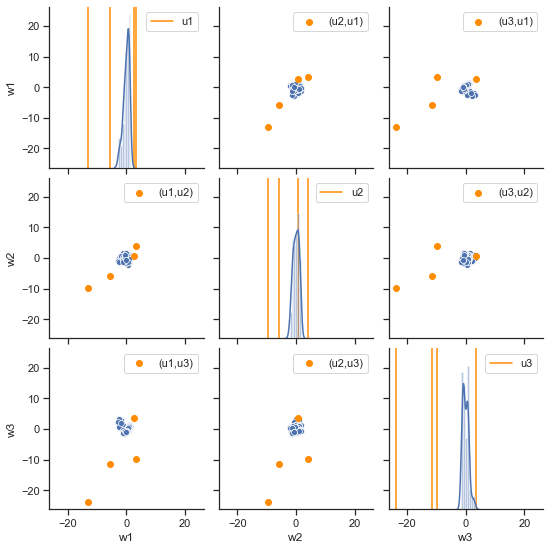

In [10]:
uw_figure = data.plot_u_w_pairs()

## MCMC with option for parameter optimization

In [11]:
override= 1
optim = 1
cachefile_name='pkls/ball_drop_2_raggedmodel.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model=pickle.load(open(cachefile_name, "rb" ))
else:
    model = SepiaModel(data)
    if optim:
        optimizer = SepiaOptim(model)
        x_opt, f_opt, f_hist, it, fnc_calls, p_native = optimizer.particle_swarm(w_max=.9,w_min=.4,c1=.5,c2=.3,\
                             maxiter=1000,swarmsize=100,obj_tol=1e-8,step_tol=1e-8,
                            log_transform=['betaU','betaV','lamUz','lamVz','lamOs','lamWOs','lamWs'],verbose=True)
        optimizer.set_model_params(p_native)
        model.tune_step_sizes(50, 20, update_vals=False)
    else:
        model.tune_step_sizes(50,20,update_vals=True)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

  0%|          | 0/1000 [00:00<?, ?it/s]

lamWOs initialized outside default bounds [60, 1e5]; setting initial value to 1e5 - 1.
optimization bounds: ([0.0, 0.0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1.2039728043259361, -1.2039728043259361, -1.2039728043259361, 4.0943445622221, 4.0943445622221, 4.0943445622221, 4.0943445622221, -1], [1.0, 1.0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229, 11.512925464970229])


Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Stopping search: Swarm best position change less than 1e-08
max obj fnc: -45009.7208589609
  param  opt value native
  theta          0.122831
  theta          0.597667
  betaV         20.085537
  betaV          4.466180
  betaU          0.234259
  betaU          0.851602
  betaU          0.162999
  betaU          0.071585
  betaU          6.859145
  betaU         14.692137
  betaU          0.370804
  betaU          0.587008
  betaU          0.770544
  betaU          1.722666
  betaU          2.984758
  betaU          0.036393
  lamVz          6.126572
  lamUz          0.300048
  lamUz          0.300049
  lamUz          0.522621
  lamWs       7532.250086
  lamWs       4361.551696
  lamWs       2174.771249
 lamWOs      99966.956189
  lamOs         54.512975
Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaV
[[0.1]
 [0.1]]
betaU
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5.]]
lamWs
[[100. 100. 100.]]
lamWOs
[[100.]]
lamOs

MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
theta
[[0.25214029 0.4680742 ]]
betaV
[[0.29354779]
 [0.08930669]]
betaU
[[0.18094234 0.05672767 0.40242369]
 [0.5328039  0.08556655 0.61450816]
 [0.07659986 0.21950538 0.43005969]
 [0.03586024 0.13968651 0.03297361]]
lamVz
[[5381.10037449]]
lamUz
[[0.20449081 0.38641123 0.60441048]]
lamWs
[[13152.20992055 10582.04148096  6012.24618753]]
lamWOs
[[136.4390666]]
lamOs
[[187.66307285]]


MCMC sampling: 100%|██████████| 5000/5000 [01:31<00:00, 54.67it/s]


In [16]:
samples_dict = model.get_samples()
theta_names = ['C','g']
p_stats = SepiaPlot.param_stats(samples_dict,theta_names=theta_names,q1=.05,q2=.95,digits=4)
print(np.round(p_stats,4))

                      mean         sd  0.05 quantile  0.95 quantile
C                   0.2082     0.0423         0.1396         0.2805
g                   0.4954     0.0782         0.3706         0.6238
betaV_1             1.3288     2.6416         0.0014         6.6190
betaV_2             0.4372     1.0493         0.0023         2.2251
betaU_1             0.2377     0.1277         0.0937         0.4713
betaU_2             0.8462     0.4181         0.4331         1.4556
betaU_3             0.2156     0.0719         0.1286         0.3534
betaU_4             0.0725     0.0208         0.0463         0.1124
betaU_5             0.1893     0.7171         0.0217         0.4353
betaU_6             0.2186     0.7731         0.0508         0.2668
betaU_7             0.8758     0.2001         0.5635         1.1989
betaU_8             0.3607     0.0880         0.2387         0.5203
betaU_9             0.6393     0.3536         0.2634         1.3178
betaU_10            0.8747     0.4436         0.

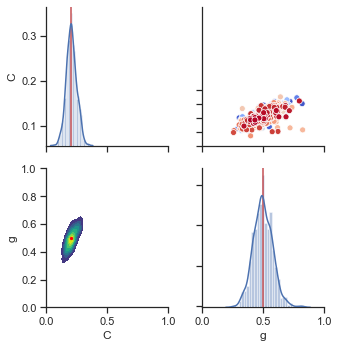

In [17]:
theta_post_fig = SepiaPlot.theta_pairs(samples_dict,theta_names,theta_ref=[[0.2075],[0.5003]],save='plots/theta_post.png')

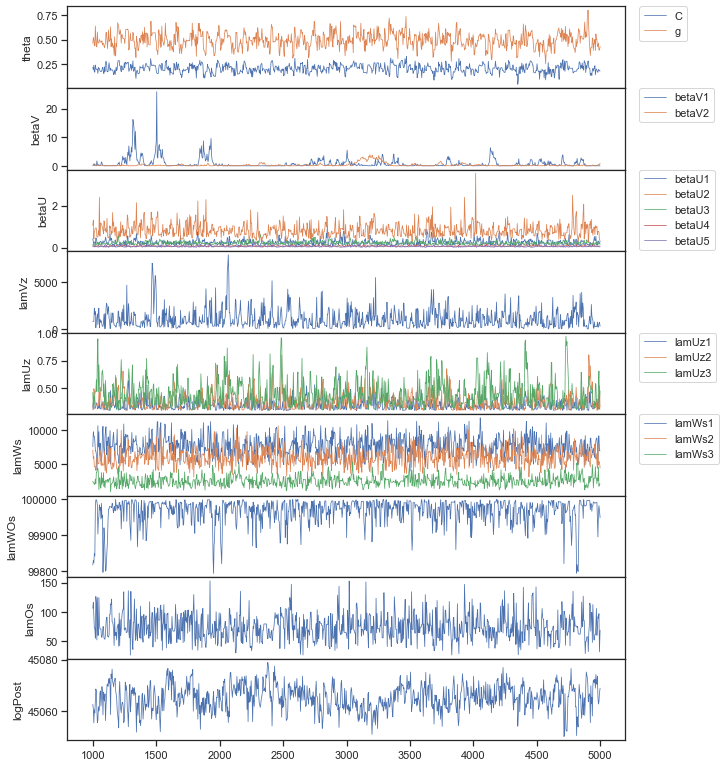

In [18]:
mcmc_trace_fig = SepiaPlot.mcmc_trace(samples_dict,theta_names,start=1000,n_to_plot=1000,max_print=5,\
                                     save='plots/mcmc_trace.png')

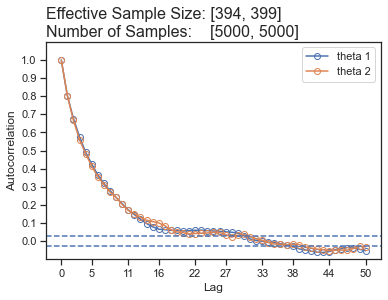

In [19]:
acf = SepiaPlot.plot_acf(model,nlags=50,nburn=0,save='plots/acf.png')